In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

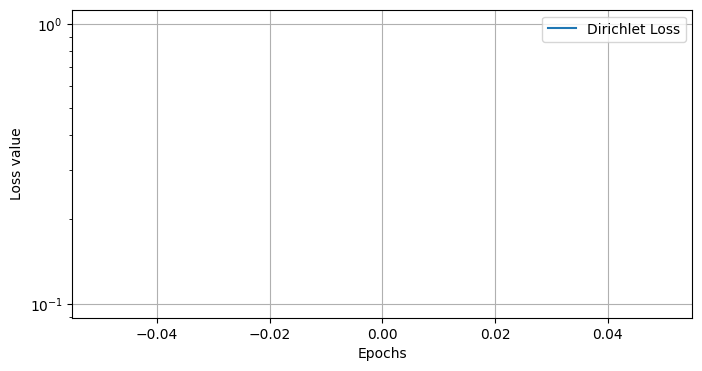

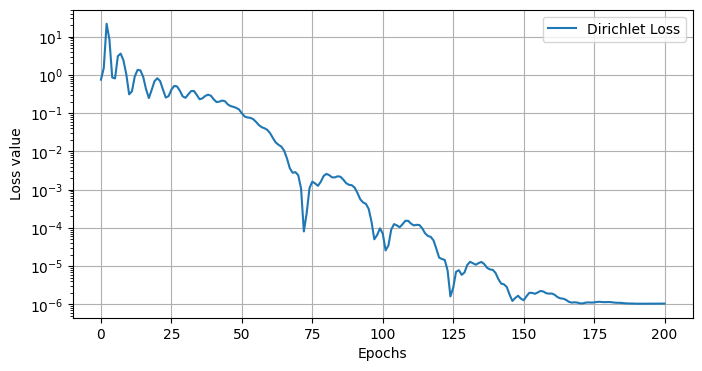

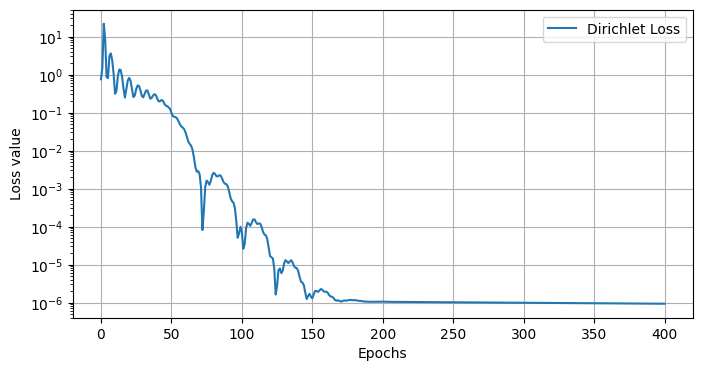

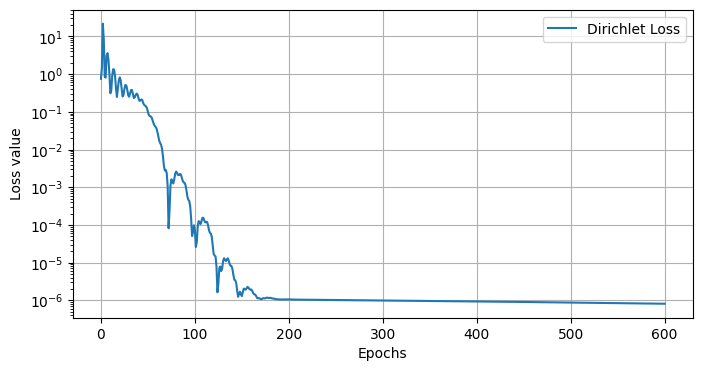

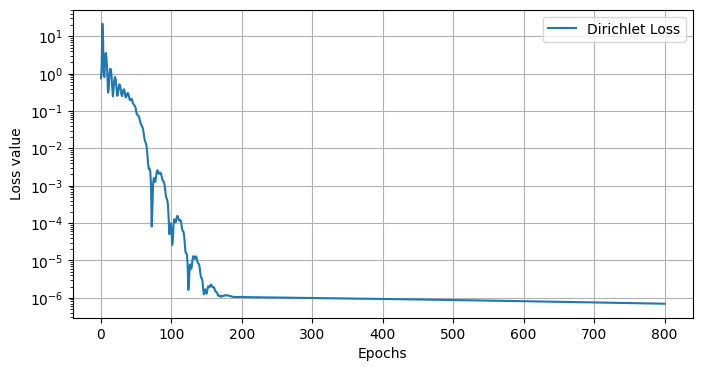

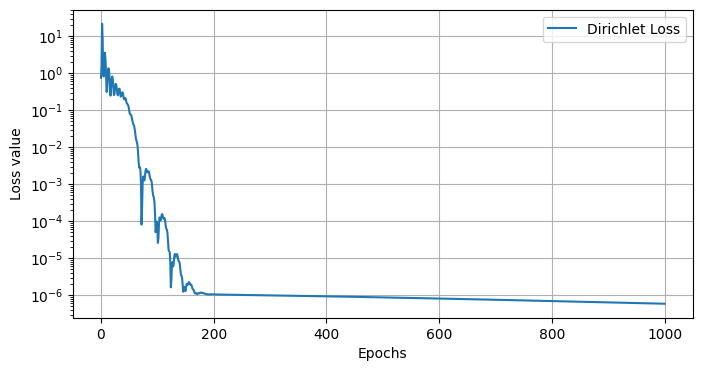

In [5]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
    return boundary_points, boundary_targets
    
def plot_losses(epochs, dirichlet_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.3

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', left, 0, top, 100, 1),  # Left boundary
    ('vertical', right, 0, top, 100, 0),  # Right boundary
    # ('horizontal', bottom, 0, right, 1000, 1),  # Bottom boundary
    ('horizontal', top, 0, 0.3*right, 0, 1),   # Top boundary]
    ('horizontal', top, 0.7*right, 1*right, 0, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Initialize lists to store losses and plot
dirichlet_losses = []
epochs_recorded = []

#Defining changeable parameters:
model=pinn(hidden_size=128, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.Adam(model.parameters(), lr=0.02) #Using the Adam optimizer
lambda_laplace, lambda_dirichlet, lambda_neumann = 1,1,1  #Weights for the losses
epochs=1001

#Training loop:
for epoch in range(epochs):
    optimizer.zero_grad()
    #losses
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss = loss_dirichlet * lambda_dirichlet# + loss_laplace * lambda_laplace   #+ loss_neumann * lambda_neumann
    # Backward pass
    loss.backward()
    optimizer.step() # Update

    # Append losses to the lists

    dirichlet_losses.append(loss_dirichlet.item())
    epochs_recorded.append(epoch) 

    # Logging
    if epoch % 200 == 0:
        plot_losses(epochs_recorded, dirichlet_losses)